# Bayesian Rasch Analysis & Posterior Predictive Checks

This notebook performs a Bayesian estimation of the Rasch model for the BLOT dataset and conducts Posterior Predictive Checks (PPC) to evaluate model fit.

## Posterior Predictive Checks (PPC) for Rasch Analysis

Posterior Predictive Checking involves simulating new datasets ($y^{rep}$) from the fitted Bayesian model and comparing them to the observed data ($y^{obs}$). If the model fits well, the observed data should look like a plausible realization from the predictive distribution.

For this analysis, we utilize the following checks:

1.  **Item Raw Score Consistency**:
    *   **Logic**: The total score of an item (how many people got it right) is a sufficient statistic for measuring item difficulty.
    *   **Check**: We calculate the distribution of *replicated* item scores summed across all persons. We compare the *observed* item score to this distribution.
    *   **Visualization**: Violin plots or Intervals of predicted scores with the observed score overlay. If the observed score falls far outside the predicted range, the item is not fitting the model (e.g., performing differently than its estimated parameter suggests).

2.  **Person Raw Score Consistency**:
    *   **Logic**: The total score of a person is the sufficient statistic for ability.
    *   **Check**: We compare the observed total score for each person against the average of their replicated total scores.
    *   **Visualization**: Scatter plot of Observed vs. Expected scores.

3.  **Global Model Fit (PPP-values)**:
    *   We can compute Bayesian p-values (PPP-values) to quantify the extremity of the observed data relative to the model predictions. A PPP-value near 0.5 implies excellent fit; values near 0 or 1 imply misfit.

In [1]:
import pandas as pd
import numpy as np
import cmdstanpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Ensure local modules can be imported
sys.path.append(os.getcwd())
try:
    from readBLOT import read_blot_data
except ImportError:
    print("Error: `readBLOT.py` not found or import failed.")

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
# 1. Load Data
print("Loading data...")
df = read_blot_data('blot.txt')
print(f"Loaded DataFrame: {df.shape}")

# 2. Preprocess Data to Long Format for Stan
item_cols = [c for c in df.columns if c != 'PersonID']
original_item_names = list(item_cols)

# Handle potential duplicate specific item names by appending index to uniquify
unique_item_names = [f"{name}_{i+1}" for i, name in enumerate(original_item_names)]
df_stan = df.copy()
df_stan.columns = ['PersonID'] + unique_item_names

# Melt
df_long = df_stan.melt(id_vars='PersonID', value_vars=unique_item_names, var_name='Item', value_name='Response')
df_long['Response'] = pd.to_numeric(df_long['Response'], errors='coerce')
df_long = df_long.dropna(subset=['Response'])
df_long['Response'] = df_long['Response'].astype(int)

# Create Integer Maps
persons = df_stan['PersonID'].unique()
person_map = {pid: i+1 for i, pid in enumerate(persons)}
items = unique_item_names
item_map = {item: i+1 for i, item in enumerate(items)}

n_persons = len(persons)
n_items = len(items)

df_long['jj'] = df_long['PersonID'].map(person_map)
df_long['kk'] = df_long['Item'].map(item_map)

print(f"Data ready for Stan: {len(df_long)} observations, {n_persons} persons, {n_items} items.")

stan_data = {
    'N_obs': len(df_long),
    'N_persons': n_persons,
    'N_items': n_items,
    'jj': df_long['jj'].values,
    'kk': df_long['kk'].values,
    'y': df_long['Response'].values
}

Loading data...
Loaded DataFrame: (150, 36)
Data ready for Stan: 5250 observations, 150 persons, 35 items.


In [3]:
# 3. Compile and Sample Model
stan_file = 'rasch.stan'
print(f"Compiling {stan_file}...")
model = cmdstanpy.CmdStanModel(stan_file=stan_file)

print("Sampling...")
# Running 500 samples for visualization speed, increase for rigorous analysis
fit = model.sample(data=stan_data, chains=4, iter_warmup=500, iter_sampling=500, show_progress=True)
print("Sampling complete.")

23:43:20 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\RaschModeling\rasch.stan to exe file C:\Users\yongd\Documents\git\RaschModeling\rasch.exe


Compiling rasch.stan...


23:43:32 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\RaschModeling\rasch.exe


Sampling...


23:43:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:43:41 - cmdstanpy - INFO - CmdStan done processing.
23:43:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'rasch.stan', line 34, column 2 to column 40)
Consider re-running with show_console=True if the above output is unclear!



Sampling complete.


In [4]:
# 4. Extract Replicated Data (y_rep)
y_rep = fit.stan_variable('y_rep')
print(f"y_rep shape: {y_rep.shape} (Draws x Observations)")

y_rep shape: (2000, 5250) (Draws x Observations)


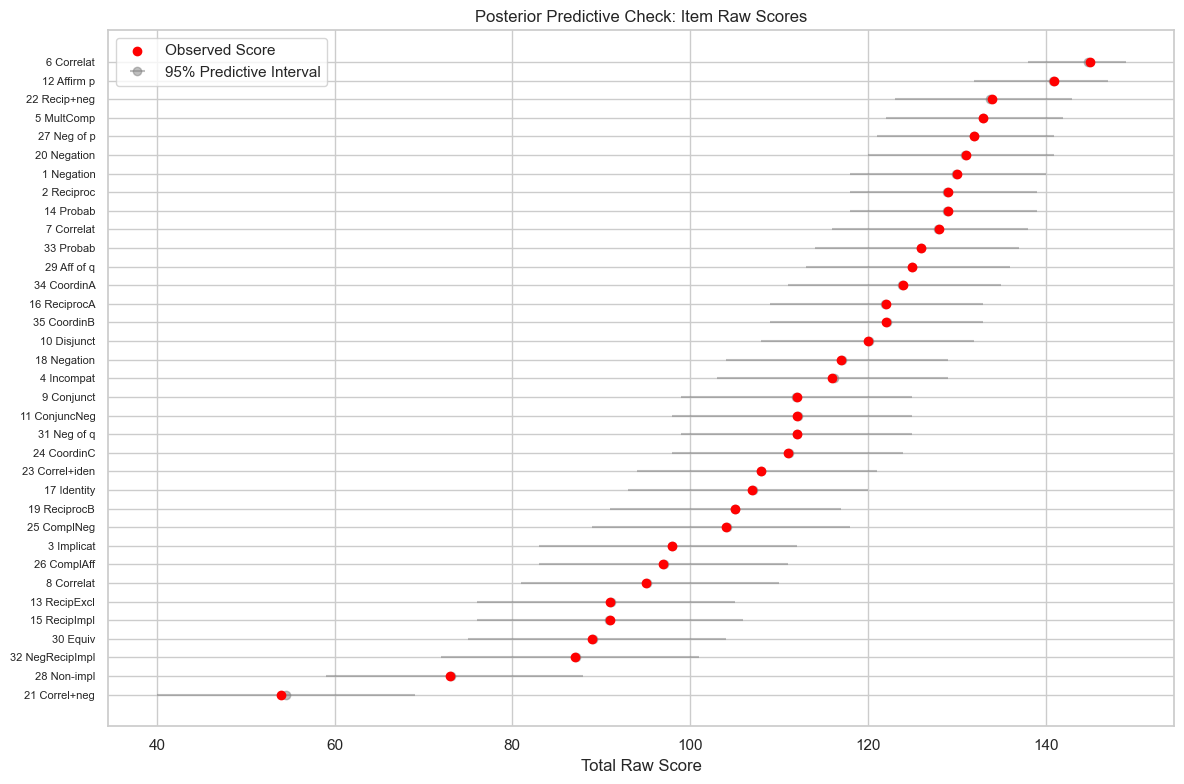

In [8]:
# 5. PPC Plot 1: Item Raw Scores
# Logic: Calculate the total score for each item in the observed data 
# and in each replicated dataset.

observed_item_scores = df_long.groupby('kk')['Response'].sum().sort_index()

# Replicated scores
# y_rep is (Draws, Obs). We need to sum over observations belonging to each item.
item_indices = df_long['kk'].values - 1 # 0-based for indexing

rep_item_scores = []
for k in range(n_items):
    # Sum y_rep columns belonging to item k
    cols = (item_indices == k)
    # Result: (Draws,) array of sums for this item
    rep_item_scores.append(np.sum(y_rep[:, cols], axis=1))

rep_item_scores = np.array(rep_item_scores).T # (Draws, n_items)

# Compute Summary Statistics for Plotting
rep_means = np.mean(rep_item_scores, axis=0)
rep_lower = np.percentile(rep_item_scores, 2.5, axis=0)
rep_upper = np.percentile(rep_item_scores, 97.5, axis=0)

# Create DataFrame for Plotting
ppc_item_df = pd.DataFrame({
    'ItemIndex': range(1, n_items + 1),
    'ItemName': original_item_names,
    'Observed': observed_item_scores.values,
    'Expected_Mean': rep_means,
    'CI_Lower': rep_lower,
    'CI_Upper': rep_upper
})

# Sort by Observed Score for better visualization
ppc_item_df_sorted = ppc_item_df.sort_values('Observed')
ppc_item_df_sorted['Rank'] = range(n_items)

# Plot
plt.figure(figsize=(12, 8))

# Plot Error Bars (Predictive Intervals)
plt.errorbar(x=ppc_item_df_sorted['Expected_Mean'], 
             y=ppc_item_df_sorted['Rank'], 
             xerr=[ppc_item_df_sorted['Expected_Mean'] - ppc_item_df_sorted['CI_Lower'], 
                   ppc_item_df_sorted['CI_Upper'] - ppc_item_df_sorted['Expected_Mean']],
             fmt='o', color='gray', alpha=0.5, label='95% Predictive Interval')

# Plot Observed Scores
plt.scatter(ppc_item_df_sorted['Observed'], ppc_item_df_sorted['Rank'], color='red', zorder=5, label='Observed Score')

# Create combined Label: "Index Name"
yticklabels = [f"{idx} {name}" for idx, name in zip(ppc_item_df_sorted['ItemIndex'], ppc_item_df_sorted['ItemName'])]
plt.yticks(ppc_item_df_sorted['Rank'], yticklabels, fontsize=8)

plt.xlabel('Total Raw Score')
plt.title('Posterior Predictive Check: Item Raw Scores')
plt.legend()
plt.tight_layout()
plt.show()

Most Difficult Item detected: 21 Correl+neg (Obs Score: 54)


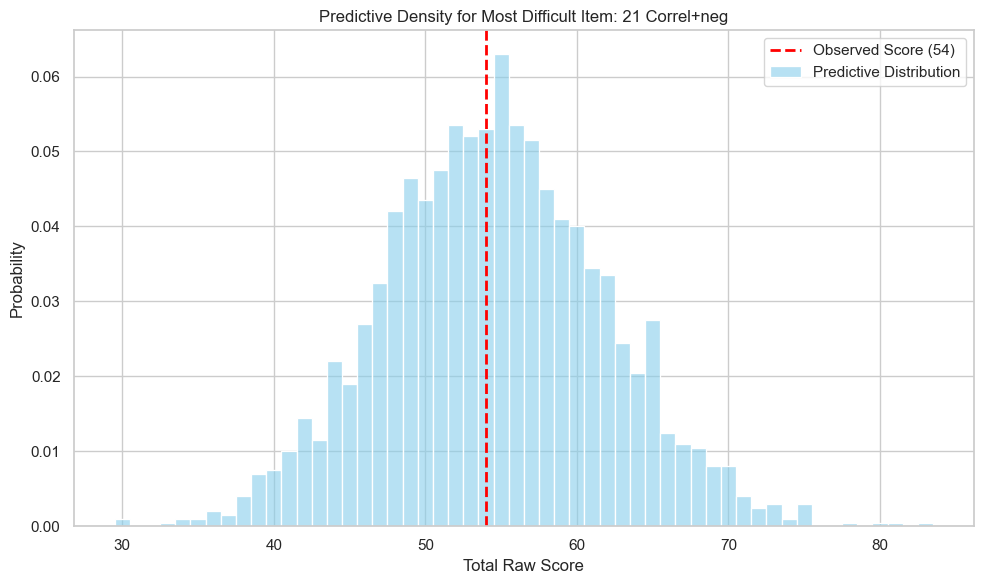

In [10]:
# 5b. Predictive Density Plot for Most Difficult Item
# Identify most difficult item (lowest expected raw score indicates highest difficulty)
hardest_item_row = ppc_item_df.nsmallest(1, 'Expected_Mean').iloc[0]
hardest_idx_0based = int(hardest_item_row['ItemIndex']) - 1
hardest_name = hardest_item_row['ItemName']
hardest_obs = hardest_item_row['Observed']
hardest_idx_label = hardest_item_row['ItemIndex']

print(f"Most Difficult Item detected: {hardest_idx_label} {hardest_name} (Obs Score: {hardest_obs})")

# Extract replicated scores for this item
# rep_item_scores is (Draws, n_items)
hardest_reps = rep_item_scores[:, hardest_idx_0based]

plt.figure(figsize=(10, 6))
# Use discrete=True for integer scores, remove KDE
sns.histplot(hardest_reps, discrete=True, stat='probability', color='skyblue', label='Predictive Distribution', alpha=0.6)
plt.axvline(hardest_obs, color='red', linestyle='--', linewidth=2, label=f'Observed Score ({hardest_obs})')

plt.title(f"Predictive Density for Most Difficult Item: {hardest_idx_label} {hardest_name}")
plt.xlabel('Total Raw Score')
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()
plt.show()

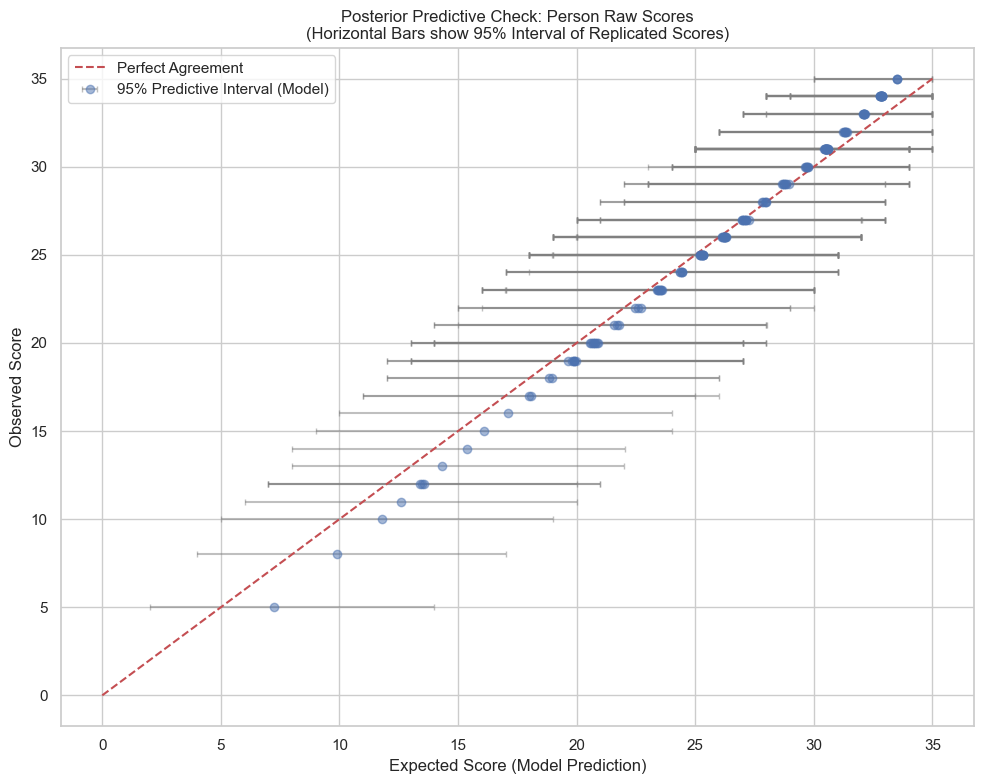

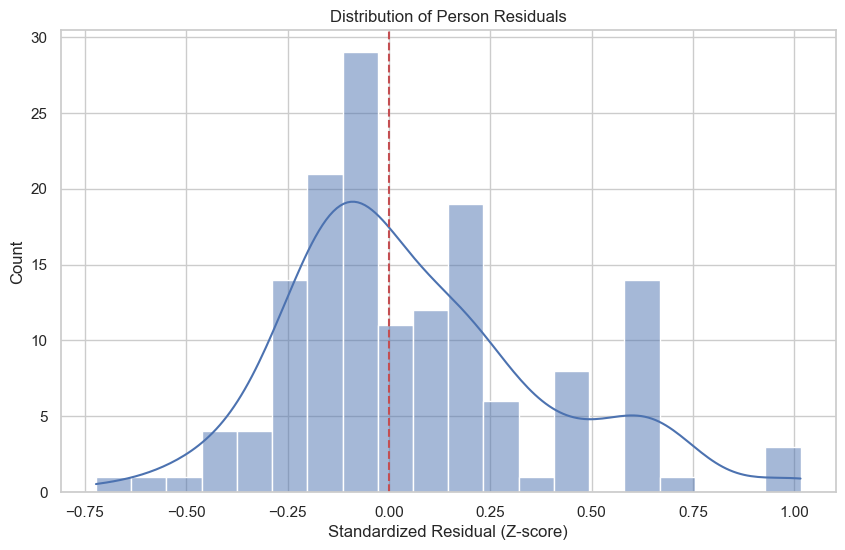

In [7]:
# 6. PPC Plot 2: Person Raw Scores
# Logic: Calculate total score for each person and compare to model prediction.

# Observed Person Scores
observed_person_scores = df_long.groupby('jj')['Response'].sum().sort_index().values

# Replicated Person Scores
person_indices = df_long['jj'].values - 1 

rep_person_scores = []
# Loop over persons (can be slow if N is huge, here N=150 is fine)
for n in range(n_persons):
    cols = (person_indices == n)
    rep_person_scores.append(np.sum(y_rep[:, cols], axis=1))
    
rep_person_scores = np.array(rep_person_scores).T # (Draws, n_persons)

# Expected (Mean of reps)
expected_person_scores = np.mean(rep_person_scores, axis=0)
person_lower = np.percentile(rep_person_scores, 2.5, axis=0)
person_upper = np.percentile(rep_person_scores, 97.5, axis=0)

# Calculate Residuals
residuals = observed_person_scores - expected_person_scores

# Plot 1: Observed vs Expected with Intervals
plt.figure(figsize=(10, 8))

# Error bars for predictive interval
# Note: xerr draws horizontal bars. Since we plot expected (x) vs observed (y), 
# the interval is technically on the outcome y given the parameters, or 
# do we want to show the range of "plausible observed scores" given the person's ability?
# In PPC, we predict NEW data y_rep. So the interval is for the Y-axis (Observed Score scale).
# Wait, typically we plot Observed (Y) vs Expected (X).
# The interval is the range of y_rep. So it should be vertical error bars on y_rep center?
# Or horizontal error bars on the x-axis if X is the "Predicted/Expected"?
# Let's clarify:
# X-axis: Expected Score (mean of y_rep)
# Y-axis: Observed Score
# The distribution y_rep is "what the score should be".
# Since X is the mean of y_rep, the Interval of y_rep is around X.
# But we are plotting Observed on Y.
# If Observed is consistent with the model, Y should fall within the interval of y_rep distributions centered approx at X.
# So we want vertical error bars? No, the interval is for the data.
# The `person_lower` and `upper` are quantiles of y_rep.
# So we want to see if `observed` (Y) falls within [`person_lower`, `person_upper`].
# However, usually we plot Observed vs Expected.
# If we put error bars on X, we are saying "The expected score is uncertain".
# But `rep_person_scores` is the distribution of PREDICTED SCORES.
# So if we plot X = Expected, Y = Observed.
# The interval [`lower`, `upper`] is the range of predicted scores.
# So for a given person, the model predicts the score will be between L and U.
# This interval is along the SCORE dimension.
# Since both axes are Score, valid points should lie near the diagonal.
# The interval [`lower`, `upper`] describes the distribution of `y_rep`.
# If we fix the observed score on Y, that's just a point.
# If we plot `y_rep` distribution, that corresponds to the range of values the model thinks is plausible.
# So we can plot the interval on the X-axis (if we view X as the prediction distribution axis)
# OR we can plot "Observed" on X and "Predicted" on Y with intervals.
# Let's stick to X=Expected, Y=Observed.
# But the interval belongs to the distribution of scores.
# X is just the mean of that distribution.
# So the interval should be around X?
# Yes. `person_lower` < `expected` < `person_upper` (roughly).
# So horizontal error bars on X make sense if X represents the model prediction range.
# Let's do horizontal error bars.

plt.errorbar(x=expected_person_scores, 
             y=observed_person_scores, 
             xerr=[expected_person_scores - person_lower, person_upper - expected_person_scores],
             fmt='o', alpha=0.5, ecolor='gray', capsize=2, label='95% Predictive Interval (Model)')

# Reference Line
plt.plot([0, n_items], [0, n_items], 'r--', label='Perfect Agreement')
plt.xlabel('Expected Score (Model Prediction)')
plt.ylabel('Observed Score')
plt.title('Posterior Predictive Check: Person Raw Scores\n(Horizontal Bars show 95% Interval of Replicated Scores)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Standardized Residual Distribution
# (Obs - Exp) / Std(Rep)
rep_std = np.std(rep_person_scores, axis=0)
z_resid = (observed_person_scores - expected_person_scores) / (rep_std + 1e-9)

plt.figure(figsize=(10, 6))
sns.histplot(z_resid, kde=True, bins=20)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Standardized Residual (Z-score)')
plt.title('Distribution of Person Residuals')
plt.show()

C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


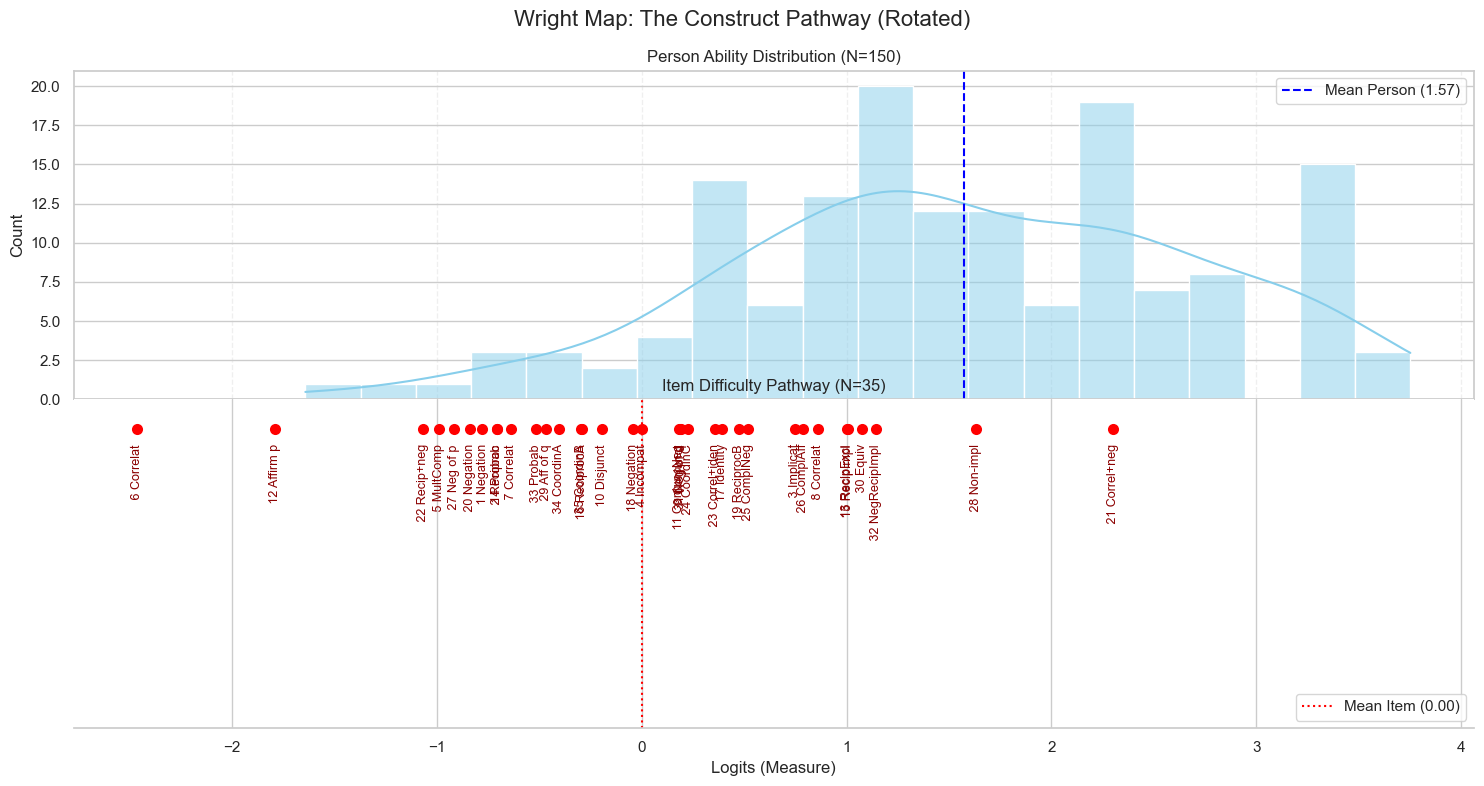

In [ ]:
# 6. Pathway Plot (Wright Map / Variable Map)
# Visualizes the "pathway" of the construct by mapping Person Abilities and Item Difficulties on the same logit scale.

import importlib
import draw_writemap
importlib.reload(draw_writemap)
from draw_writemap import draw_wright_map

# Extract posterior means for Person Ability (theta) and Item Difficulty (beta)
theta_samples = fit.stan_variable('theta')
beta_samples = fit.stan_variable('beta')

person_abilities = np.mean(theta_samples, axis=0)
item_difficulties = np.mean(beta_samples, axis=0)

# Calls the external function to draw the plot
draw_wright_map(person_abilities, item_difficulties, original_item_names)

c:\Users\yongd\Documents\git\RaschModeling\draw_pathway.py:49: SyntaxWarning: invalid escape sequence '\p'
  plt.scatter(person_fits, person_locations, s=sizes_p, c='blue', marker='s', alpha=0.4, label='Persons (Size $\propto$ SE)')
c:\Users\yongd\Documents\git\RaschModeling\draw_pathway.py:58: SyntaxWarning: invalid escape sequence '\p'
  plt.scatter(item_fits, item_locations, s=sizes_i, c='hotpink', marker='o', edgecolors='black', alpha=0.6, label='Items (Size $\propto$ SE)')
c:\Users\yongd\Documents\git\RaschModeling\draw_pathway.py:74: SyntaxWarning: invalid escape sequence '\p'
  title_str += '\nSymbol Radius $\propto$ Standard Error (Larger = Less Precise)'


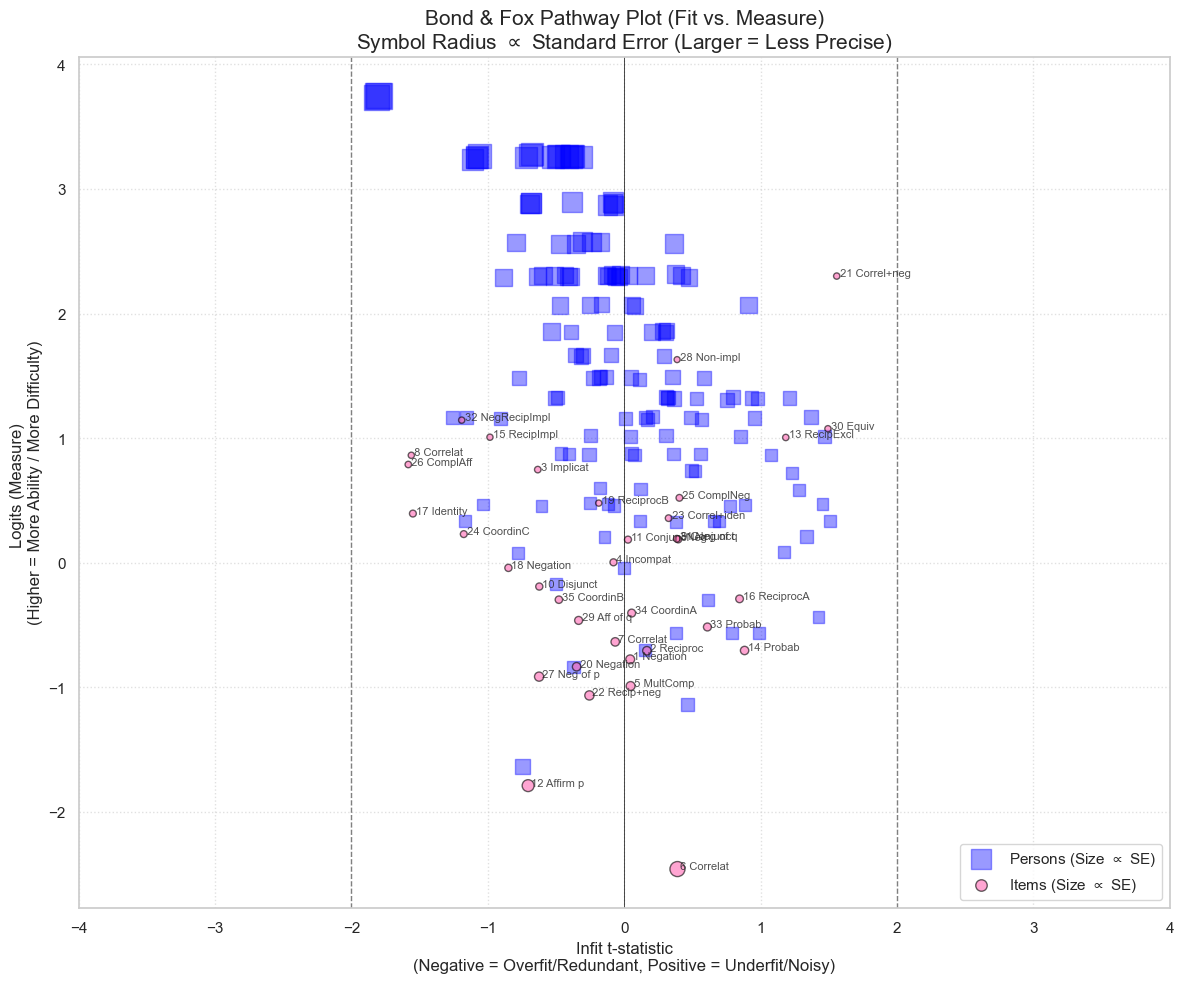

In [23]:
# 7. Bond & Fox Pathway Plot (Fit vs. Measure)
# This plot maps Person Abilities and Item Difficulties against their Fit Statistics (Infit t-stat).
# Y-Axis: Logit Measure (Ability/Difficulty)
# X-Axis: Infit t-statistic (Standardized Fit)
# Symbol Size: Proportional to Precision (1/Standard Error)

from scipy.special import expit
import importlib
import draw_pathway
importlib.reload(draw_pathway)
from draw_pathway import draw_pathway

# --- 1. Calculate Fit Statistics (Infit t) using Point Estimates ---
# Reconstruct Probability Matrix
theta = person_abilities # (N,)
beta = item_difficulties # (K,)
# Create meshgrid for vectorized calculation
# We assume data is rectangular (N x K). If missing, we'd need masking. 
# Based on read_blot_data, we likely have a full matrix.
# Pivot df_long to get observed matrix aligned with indices
obs_matrix_df = df_long.pivot(index='jj', columns='kk', values='Response')
# Ensure sorted by index (1..N, 1..K)
obs_matrix = obs_matrix_df.sort_index(axis=0).sort_index(axis=1).values
# N, K
N, K = obs_matrix.shape

# Compute Expected Probabilities P_ni
# Broadcasting: theta (N,1) - beta (1,K)
logits = theta[:, np.newaxis] - beta[np.newaxis, :]
probs = expit(logits)
variances = probs * (1 - probs) # W_ni

# Weighted Residuals for Infit
residuals = obs_matrix - probs
sq_resid = residuals ** 2

# -- Person Infit --
# Sum over Items (axis 1)
w_sum_p = np.sum(variances, axis=1) # Sum W_ni
infit_mnsq_p = np.sum(sq_resid, axis=1) / w_sum_p
# Standard Deviation of Infit MNSQ (Approx for t-stat)
# Var(Infit) = Sum(W(1-4W)??) / (Sum W)^2? 
# Using Wright & Masters approx: q_p = sum(W_ni - 4*W_ni^2) / (sum W_ni)^2 ?? 
# Actually simpler approximation often used: High variance ~ high info.
# Let's use the explicit variance term for t-stat calculation:
# var_infit_msq = sum( P(1-P) * ( (y-P)^2 / Var - MNSQ )^2 ) ?
# Winsteps formula:
# Q = Sigma( (obs-exp)^2 * Prob * (1-Prob) ) ... no.
# Let's use simple approximation: SD_infit = sqrt(2/K)? No, depends on target.
# Let's simple calculate MNSQ for now, and standardizing might be complex without a library.
# HOWEVER, the plotPWmap documentation explicitly mentions "Infit t-statistic".
# We will use the Cube Root fit transformation (Wilson-Hilferty):
# t = (MNSQ^(1/3) - 1) * (3 / sigma) + (sigma / 3)
# where sigma^2 = variance of MNSQ.
# Variance of Infit MNSQ_n = ( \sum_i (W_ni - 4 W_ni^2) ) / ( \sum_i W_ni )^2  (Wright & Masters, 1982)

# Vectorized Sigma calculation for Persons
sig2_p = np.sum(variances - 4 * (variances**2), axis=1) / (w_sum_p**2)
sig_p = np.sqrt(sig2_p)
infit_t_p = (infit_mnsq_p**(1/3) - 1) * (3/sig_p) + (sig_p/3)

# -- Item Infit --
# Sum over Persons (axis 0)
w_sum_i = np.sum(variances, axis=0)
infit_mnsq_i = np.sum(sq_resid, axis=0) / w_sum_i
# Vectorized Sigma calculation for Items
sig2_i = np.sum(variances - 4 * (variances**2), axis=0) / (w_sum_i**2)
sig_i = np.sqrt(sig2_i)
infit_t_i = (infit_mnsq_i**(1/3) - 1) * (3/sig_i) + (sig_i/3)

# --- 2. Calculate Standard Errors for Sizing ---
# We have posterior samples. SE = Std Dev of posterior.
se_p = fit.stan_variable('theta').std(axis=0)
se_i = fit.stan_variable('beta').std(axis=0)

# --- 3. Draw Plot using External Function ---
draw_pathway(
    person_locations=theta,
    person_fits=infit_t_p,
    person_se=se_p,
    item_locations=beta,
    item_fits=infit_t_i,
    item_se=se_i,
    item_labels=original_item_names,
    base_size=100
)